# Automated ML

In [11]:
from azureml.core import Experiment, Dataset, Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice

import pandas as pd
import logging

## Attrition Dataset

### Overview

This is a fictional dataset made by the IBM data scientists to find relations between dependent and independent variables. The prediction task consist in detect the factors that lead to employee attrition.

In [2]:
data_path = "https://raw.githubusercontent.com/jaircastruita/nd00333-capstone/master/starter_file/data/WA_Fn-UseC_-HR-Employee-Attrition.csv"

ibm_ds = Dataset.Tabular.from_delimited_files(path=data_path)
# ds = Dataset.get_by_name(ws, 'attrition-dataset')

In [3]:
ibm_ds.to_pandas_dataframe().head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-experiment'

experiment=Experiment(ws, experiment_name)

## Creating a compute instance

In [5]:
cluster_name = "automl-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Reusing already created cluster: {}".format(cluster_name))

except ComputeTargetException:
    print("Creating a new compute cluster...")
    cluster_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=5)
    compute_target = ComputeTarget.create(workspace=ws, name=cluster_name, provisioning_configuration=cluster_config)

compute_target.wait_for_completion(show_output=True)

Reusing already created cluster: automl-cluster
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

Given the nature of the selected dataset: tabular, with categorical and numeric columns, relatively few observations with relatively many columns, the following settings were selected in the automl configuration:

- *iteration_timeout_minutes* to 20, just to make sure the experiment will finish in a feasible time
- *enable_early_stopping* to True in order to not waste resources when the model performance is not improving
- *primary_metric* "AUC_weighted" given we are facing an umbalanced dataset problem
- *verbosity* logging.INFO to capture important events for the model experiments
- *max_concurrent_iterations* to 5 in order to parallelize experimentation
- *n_cross_validations* to 5 to give an estimated 80-20 proportion to the training-testing sets in each fold
- *task* will be "classification" because the objective is to identify attrition as a "Yes", "No" labeling problem 

In [6]:
automl_settings = {"iteration_timeout_minutes": 20,
                    "enable_early_stopping": True,
                    "primary_metric": "AUC_weighted",
                    "verbosity": logging.INFO,
                    "max_concurrent_iterations": 5,
                    "n_cross_validations": 5
                    }

automl_config = AutoMLConfig(task="classification",
                             compute_target=compute_target,
                             training_data=ibm_ds,
                             label_column_name="Attrition",
                             **automl_settings)

In [7]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion(show_output=True)

Running on remote.
No run_configuration provided, running on automl-cluster with default configuration
Running on remote compute: automl-cluster
Parent Run ID: AutoML_087c6ad3-ea12-4397-aec0-abb21503bc96



In [7]:
# from azureml.train.automl.run import AutoMLRun

# remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_087c6ad3-ea12-4397-aec0-abb21503bc96')
# remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-experiment,AutoML_087c6ad3-ea12-4397-aec0-abb21503bc96,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

In [8]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model



In [9]:
best_automl_run, best_automl_model = remote_run.get_output()

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


In [ ]:
print(best_automl_model)

In [ ]:
best_automl_run

In [ ]:
get_best_automl_metrics = best_automl_run.get_metrics()

for metric_name in get_best_automl_metrics:
    metric = get_best_automl_metrics[metric_name]
    print(metric_name, metric)

View updated transformation summary

In [12]:
custom_featurizer = best_automl_model.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary(is_user_friendly=True)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Age,Categorical,No,43,[StringCast-CharGramCountVectorizer]
1,BusinessTravel,Categorical,No,3,[StringCast-CharGramCountVectorizer]
2,Department,Categorical,No,3,[StringCast-CharGramCountVectorizer]
3,DistanceFromHome,Categorical,No,29,[StringCast-CharGramCountVectorizer]
4,Education,Categorical,No,5,[StringCast-CharGramCountVectorizer]
5,EducationField,Categorical,No,6,[StringCast-CharGramCountVectorizer]
6,EnvironmentSatisfaction,Categorical,No,4,[StringCast-CharGramCountVectorizer]
7,Gender,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
8,JobInvolvement,Categorical,No,4,[StringCast-CharGramCountVectorizer]
9,JobLevel,Categorical,No,5,[StringCast-CharGramCountVectorizer]


In [13]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,Age,Categorical,No,43,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Age'], 'Transform..."
1,BusinessTravel,Categorical,No,3,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['BusinessTravel'],..."
2,Department,Categorical,No,3,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Department'], 'Tr..."
3,DistanceFromHome,Categorical,No,29,[StringCast-CharGramCountVectorizer],{'Transformer1': {'Input': ['DistanceFromHome'...
4,Education,Categorical,No,5,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Education'], 'Tra..."
5,EducationField,Categorical,No,6,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['EducationField'],..."
6,EnvironmentSatisfaction,Categorical,No,4,[StringCast-CharGramCountVectorizer],{'Transformer1': {'Input': ['EnvironmentSatisf...
7,Gender,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Gender'], 'Transf..."
8,JobInvolvement,Categorical,No,4,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['JobInvolvement'],..."
9,JobLevel,Categorical,No,5,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['JobLevel'], 'Tran..."


In [15]:
# df = custom_featurizer.get_stats_feature_type_summary()
# pd.DataFrame(data=df)

""


## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [22]:
model_name = best_automl_run.properties["model_name"]
script_file_name = "inference/score.py"
best_automl_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [23]:
print(remote_run.model_id)

None


In [25]:
# Register the model to deploy
# model = run.register_model(model_name = "mymodel", model_path = "outputs/model.pkl")
description = 'sample service for Automl Classification'
model = best_automl_run.register_model(description = description,
                                       model_name=model_name,
                                       tags={'area': "Attrition", 'type': "automl_classification"},
                                       model_path = "outputs/model.pkl")

# Combine scoring script & environment in Inference configuration
inference_config = InferenceConfig(entry_script=script_file_name)

# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, 
                                                       memory_gb=1,
                                                       tags={'area': "AttritionData", 'type': "automl_classification"},
                                                       description='sample service for Automl Classification')

# Define the model, inference, & deployment configuration and web service name and location to deploy
service = Model.deploy(
    workspace=ws,
    name="automl-web-service",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config)

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [34]:
print(service.scoring_uri)

http://fb677e09-e443-4274-8359-1a7840d64bad.southcentralus.azurecontainer.io/score


In [ ]:
# Enable application insights
service.update(enable_app_insights = True)

In [ ]:
print("State : "+service.state)
print("Key " + service.get_keys()[0])
print("Swagger URI : "+service.swagger_uri)
print("Scoring URI : "+service.scoring_uri)

TODO: In the cell below, send a request to the web service you deployed to test it.

In [26]:
from numpy import array

In [29]:
X_test = ibm_ds.drop_columns(columns=['Attrition'])
y_test = ibm_ds.keep_columns(columns=['Attrition'], validate=True)

In [31]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [35]:
import json
import requests

X_test_json = X_test.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [36]:
actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

1470   1470


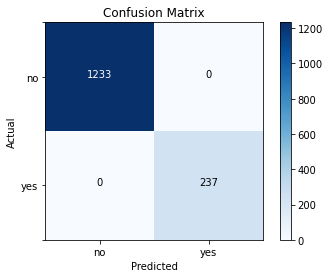

In [43]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

TODO: In the cell below, print the logs of the web service and delete the service

In [40]:
print(service.get_logs())

'2021-02-18T01:07:48,081044795+00:00 - gunicorn/run \n2021-02-18T01:07:48,081759702+00:00 - iot-server/run \n2021-02-18T01:07:48,085241638+00:00 - nginx/run \n2021-02-18T01:07:48,082787213+00:00 - rsyslog/run \n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [42]:
service.delete()

In [ ]:
compute_target.delete()